# TP n°3/4 : Image reconstruction in X-ray tomography

## X-Ray Tomography

Merci à M.Chalvidal (chargé de TD) pour son aide tant sur la partie programmation (Gitlab) que sur la partie théorique

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.sparse.linalg import svds

In [2]:
H = loadmat(os.path.join("data", "H"))
H = H['H']
print(H.shape)

(16200, 8100)


In [3]:
x = loadmat(os.path.join("data", "x"))
x = x['x']
print(x.shape)

(8100, 1)


In [4]:
M  = H.shape[0]
N = H.shape[1]

In [5]:
w = np.random.normal(0,1,M)

In [6]:
y = H.dot(x).reshape(16200) + w

In [7]:
y.shape

(16200,)

### Signal 

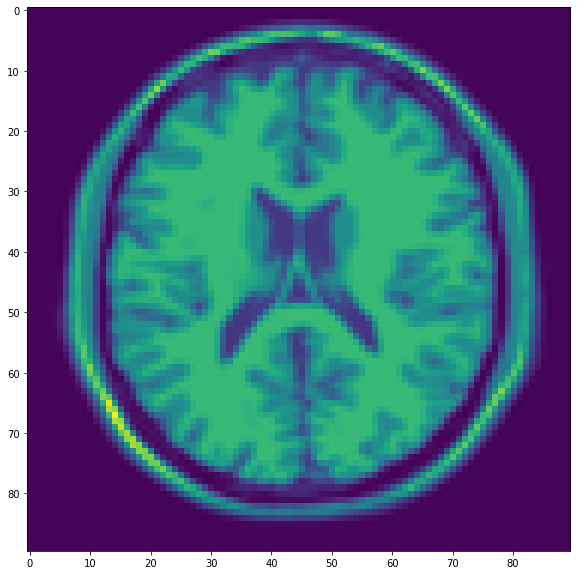

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(x.reshape(90,90,order='F'))

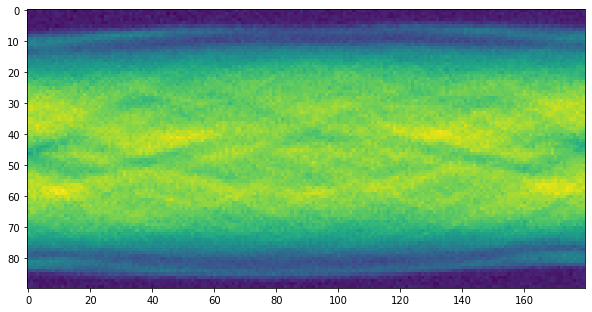

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(y.reshape(90,180,order='F'))

## Optimization problem

In [10]:
lamb, delt = 0.13, 0.02

In [11]:
G = loadmat(os.path.join("data", "G"))
G = G['G']

### Calculons le gradient de f

La fonction f est bien dérivable pour tout x car c'est la somme de deux fonctions dérivables, et on a :
Pour tout 0<i<2N+1,
$$[\nabla f(x)]_{i} = H^THx - H^Ty + \frac{\lambda}{\delta^2}G^T\frac{[Gx]^{(i)}}{\sqrt{1 + (\frac{[Gx]^{(i)}}{\delta})^2}}$$ 

In [12]:
def grad_f(x):
    term_one = H.T.dot(H.dot(x)-y) 
    term_two = (lamb/delt**2)* G.T.dot((G.dot(x)/np.sqrt(1+(G.dot(x)/delt)**2)))
    res = term_one + term_two
    return res

Pour x, y dans le domaine de définition du gradient de f, on a : 
$$ \|\nabla f(x) - \nabla f(y) = \| H^TH(x-y) + \frac{\lambda}{\delta^2}G^T(\frac{[G(x-y)]^{(i)}}{\varphi([G(x-y)]^{(i)})}) \|$$

L'inégalité triangulaire donne
$$ \|\nabla f(x) - \nabla f(y) \| \leq \| H^TH(x-y) \| +  \frac{\lambda}{\delta^2}\|G^T \| \|(\frac{[G(x-y)]^{(i)}}{\varphi([G(x-y)]^{(i)})} )\|$$

Comme on a pour tout x, $\|\frac{x}{\varphi(x)}\| < \|x\|$ 
On en déduit que, $$ \|\nabla f(x) - \nabla f(y) \| \leq \| H^TH \| \|x-y\| +  \frac{\lambda}{\delta^2}\|G^T \| \|G(x-y)\|$$

$$ \|\nabla f(x) - \nabla f(y) \| \leq \| H^TH \| \|x-y\| +  \frac{\lambda}{\delta^2}\|G^T \| \|G\|\|x-y\|$$

En factorisant pas $\|x-y\|$, il veint que $\nabla f$ est $L$-lipschitzien avec $L = \|H\|^{2} + \frac{\lambda}{\delta^2}\|G\|^{2}$

Calcul effectué par le chargé de TD M.Chalvidal

In [13]:
def L_lip(lamb, delt):
    max_sing_H  = np.max(svds(H)[1])
    max_sing_G  = np.max(svds(G)[1])
    return max_sing_H**2 + (lamb/delt**2)*max_sing_G**2

In [14]:
L_lip(lamb, delt)

18092.77327686479

## Optimization algorithms

### Gradient descent algorithm

In [48]:
x_0 = np.zeros(N)
import time
L = L_lip(lamb, delt)

In [16]:
def basic_gradient_descent():
    gamma = 1.98/L
    x_n = x_0
    tol = np.sqrt(N)*10**-4
    error = 1
    
    times= {}
    times[0] = np.linalg.norm(grad_f(x_n))
    start = time.time()
    
    max_it = 5000
    it = 0
    
    while tol < error and it < max_it:
        grad = grad_f(x_n)
        x_new = x_n - gamma*grad
        
        error = np.linalg.norm(grad)
        
        x_n = x_new
        it = it + 1
        
        times[time.time()-start] = error
        
    return (x_n, times, it)

In [17]:
x_grad_desc, times_desc, it_desc = basic_gradient_descent()

In [18]:
x_grad_desc

array([-0.00556264,  0.00348951,  0.00965373, ...,  0.00187952,
        0.00621544, -0.00051148])

In [19]:
it_desc

2449

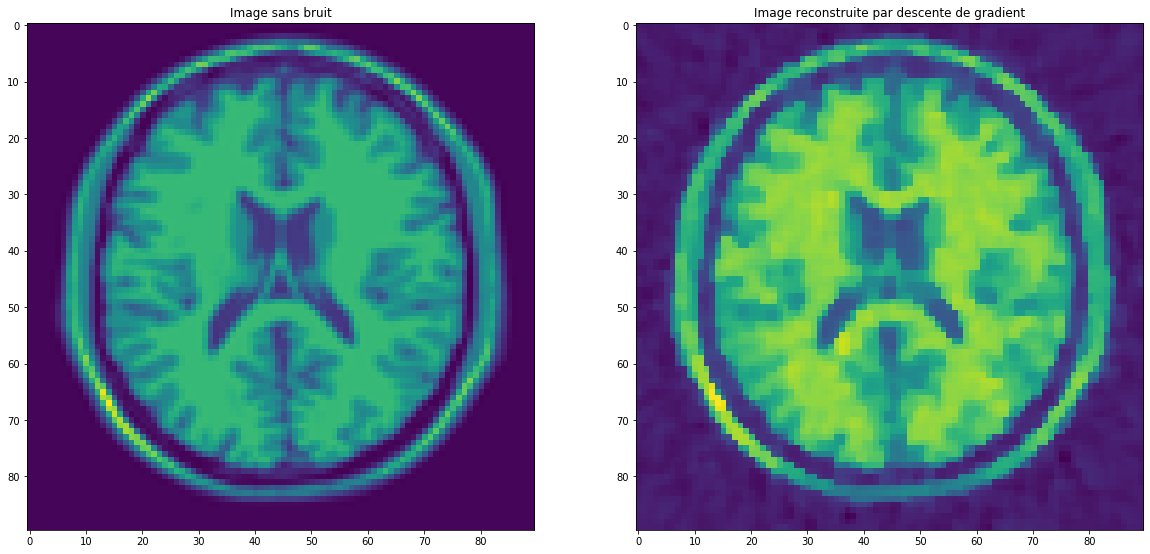

In [20]:
fig, a = plt.subplots(1,2,figsize=(20,20))
a[0].set_title('Image sans bruit')
a[0].imshow(x.reshape(90,90,order='F'))
a[1].set_title('Image reconstruite par descente de gradient')
a[1].imshow(x_grad_desc.reshape(90,90,order='F'))

### MM quadratic algorithm

In [21]:
from scipy.sparse.linalg import LinearOperator
from scipy.sparse import diags
from scipy.sparse.linalg import bicg

In [22]:
def A_mm(x):
    diag = 1/np.sqrt(1+(G.dot(x)/delt)**2)
    Diag = diags(diag).tocsc()
    A_func = lambda x: H.T.dot(H.dot(x)) + (lamb/delt**2)*G.T.dot(Diag.dot(G.dot(x)))
    res = LinearOperator((N,N), matvec = A_func)
    res.rmatvec = A_func
    return res

In [23]:
def MM_algo():
    theta = 1
    x_n = x_0
    tol = np.sqrt(N)*10**-4
    error = 1
    
    times= {}
    times[0] = np.linalg.norm(grad_f(x_n))
    start = time.time()
    
    max_it = 5000
    it = 0
    
    while tol < error and it < max_it:
        dist = bicg(A_mm(x_n), grad_f(x_n), maxiter = 200)[0]
        x_new = x_n - theta*dist
        
        error = np.linalg.norm(grad_f(x_n))
        
        x_n = x_new
        it = it + 1
        
        times[time.time()-start] = error
        
    return (x_n, times, it)
    

In [24]:
x_mm_quad, times_mm, it_mm = MM_algo()

In [25]:
x_mm_quad

array([-0.00556265,  0.0034895 ,  0.00965374, ...,  0.00187954,
        0.00621545, -0.00051149])

In [26]:
it_mm

67

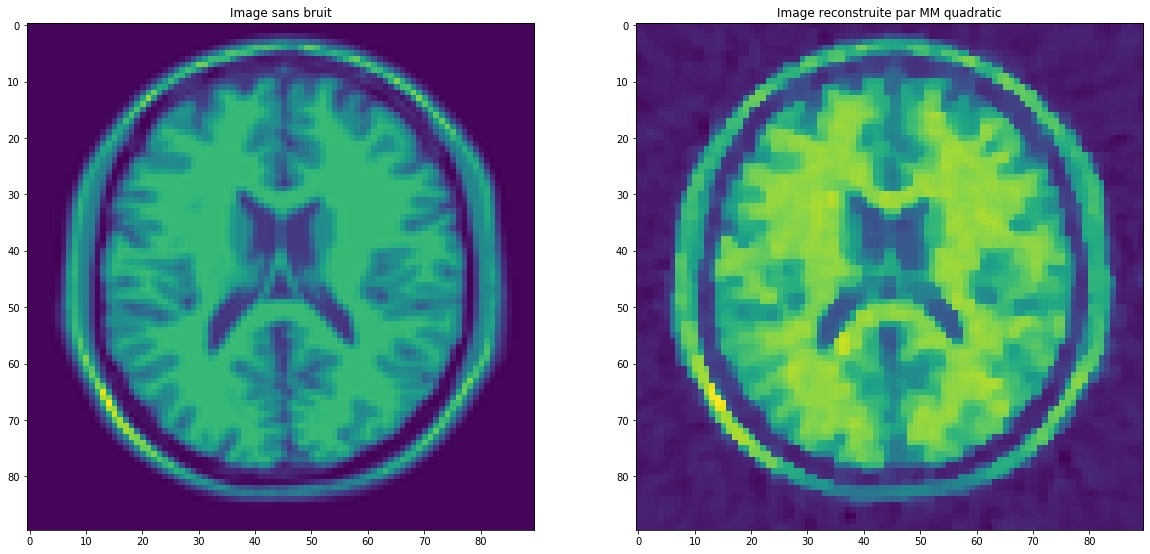

In [27]:
fig, a = plt.subplots(1,2,figsize=(20,20))
a[0].set_title('Image sans bruit')
a[0].imshow(x.reshape(90,90,order='F'))
a[1].set_title('Image reconstruite par MM quadratic')
a[1].imshow(x_mm_quad.reshape(90,90,order='F'))

### 3-MG Algorithm

In [28]:
def A_3mg(x, D):
    diag = 1/np.sqrt(1+(G.dot(x)/delt)**2)
    Diag = diags(diag).tocsc()
    B = (H@D).T.dot(H@D) + (lamb/delt**2)*(G@D).T.dot(Diag.dot(G@D))
    return B

In [29]:
from scipy.linalg import pinv

def _3MG_algo():
    theta = 1
    x_n = x_0
    x_old = x_0
    tol = np.sqrt(N)*10**-4
    error = 1
    
    times= {}
    times[0] = np.linalg.norm(grad_f(x_n))
    start = time.time()
    
    max_it = 5000
    it = 0
    
    while tol < error and it < max_it:
        if it == 0:
            D = - grad_f(x_n)
            u = (D.T.dot(grad_f(x_n)))/A_3mg(x_n, D)
             
        else:
            D = np.vstack((-grad_f(x_n),x_n-x_old)).T
            u = pinv(A_3mg(x_n, D))@(D.T.dot(grad_f(x_n)))
            
        #u = pinv(D.T.dot(A_mm(x_n).dot(D))).dot(D.T.dot(grad_f(x_n)))
        x_new = x_n - theta*D.dot(u)
        
        error = np.linalg.norm(grad_f(x_n))
        x_old = x_n
        x_n = x_new
        it = it + 1
        
        times[time.time()-start] = error
        
    return (x_n, times, it)
    

In [30]:
x_3mg_quad, times_3mg, it_3mg = _3MG_algo()

In [31]:
x_3mg_quad

array([-0.00556244,  0.00348968,  0.00965385, ...,  0.00187965,
        0.00621556, -0.00051131])

In [32]:
it_3mg

150

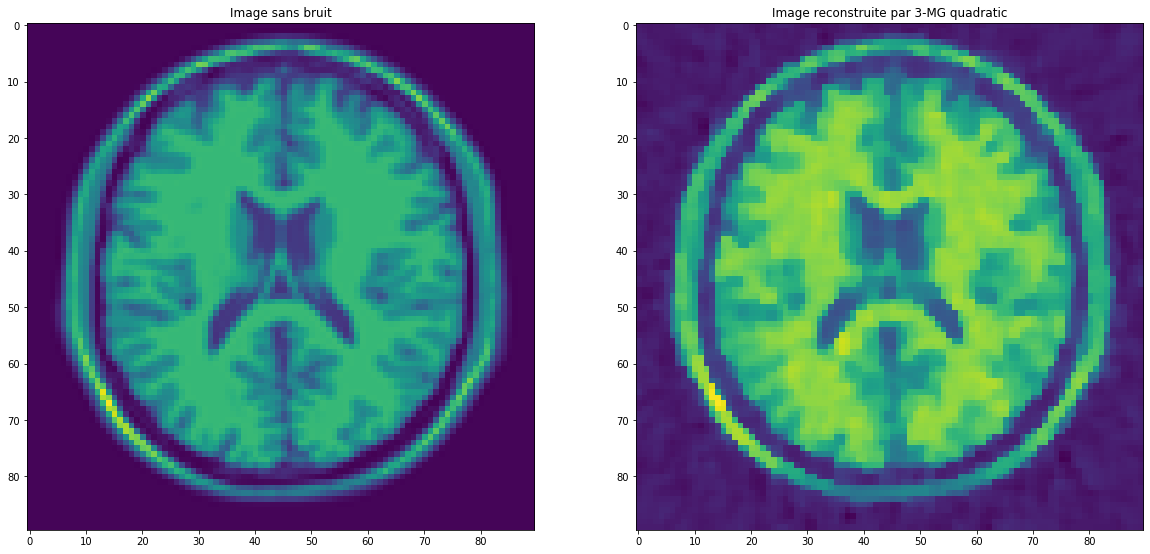

In [33]:
fig, a = plt.subplots(1,2,figsize=(20,20))
a[0].set_title('Image sans bruit')
a[0].imshow(x.reshape(90,90,order='F'))
a[1].set_title('Image reconstruite par 3-MG quadratic')
a[1].imshow(x_3mg_quad.reshape(90,90,order='F'))

### Block-coordinate MM quadratic algorithm

In [59]:
def A_bloc(x, j, N_j):
    x_j = x[int((j-1)*N_j):int(j*N_j)]
    G_j = G[:, int((j-1)*N_j):int(j*N_j)]
    H_j = H[:, int((j-1)*N_j):int(j*N_j)]
    diag = 1/np.sqrt(1+(G_j.dot(x_j)/delt)**2)
    Diag = diags(diag).tocsc()
    A_func = lambda x_j: H_j.T.dot(H_j.dot(x_j)) + (lamb/delt**2)*G_j.T.dot(Diag.dot(G_j.dot(x_j)))
    res = LinearOperator((int(N_j),int(N_j)), matvec = A_func)
    res.rmatvec = A_func
    return res

In [60]:
def Block_MM_algo(K):
    x_0 = np.zeros(N)
    theta = 1
    x_n = x_0
    tol = np.sqrt(N)*10**-4
    error = 10**4
    
    times= {}
    times[0] = np.linalg.norm(grad_f(x_n))
    start = time.time()
    
    max_it = 5000
    it = 0
    k = 0
    
    N_j = N/K
    
    while tol < error and it < max_it:
        j = (k-1) % K + 1
        k = k + 1
        dist = bicg(A_bloc(x_n, j, N_j), grad_f(x_n)[int((j-1)*N_j):int(j*N_j)], maxiter = 200)[0]
        x_new = x_n 
        x_new[int((j-1)*N_j):int(j*N_j)] = x_n[int((j-1)*N_j):int(j*N_j)] - theta*dist
        
        error = np.linalg.norm(grad_f(x_n))
        
        x_n = x_new
        it = it + 1
        
        times[time.time()-start] = error
        
    return (x_n, times, it)

In [61]:
x_bloc_quad, times_bloc, it_bloc = Block_MM_algo(K = 2)

In [62]:
x_bloc_quad_3, times_bloc_3, it_bloc_3 = Block_MM_algo(K = 3)
x_bloc_quad_5, times_bloc_5, it_bloc_5 = Block_MM_algo(K = 5)
x_bloc_quad_6, times_bloc_6, it_bloc_6 = Block_MM_algo(K = 6)
x_bloc_quad_9, times_bloc_9, it_bloc_9 = Block_MM_algo(K = 9)

In [69]:
x_bloc_quad

array([-0.00556266,  0.0034895 ,  0.00965375, ...,  0.00187954,
        0.00621545, -0.0005115 ])

In [66]:
it_bloc

132

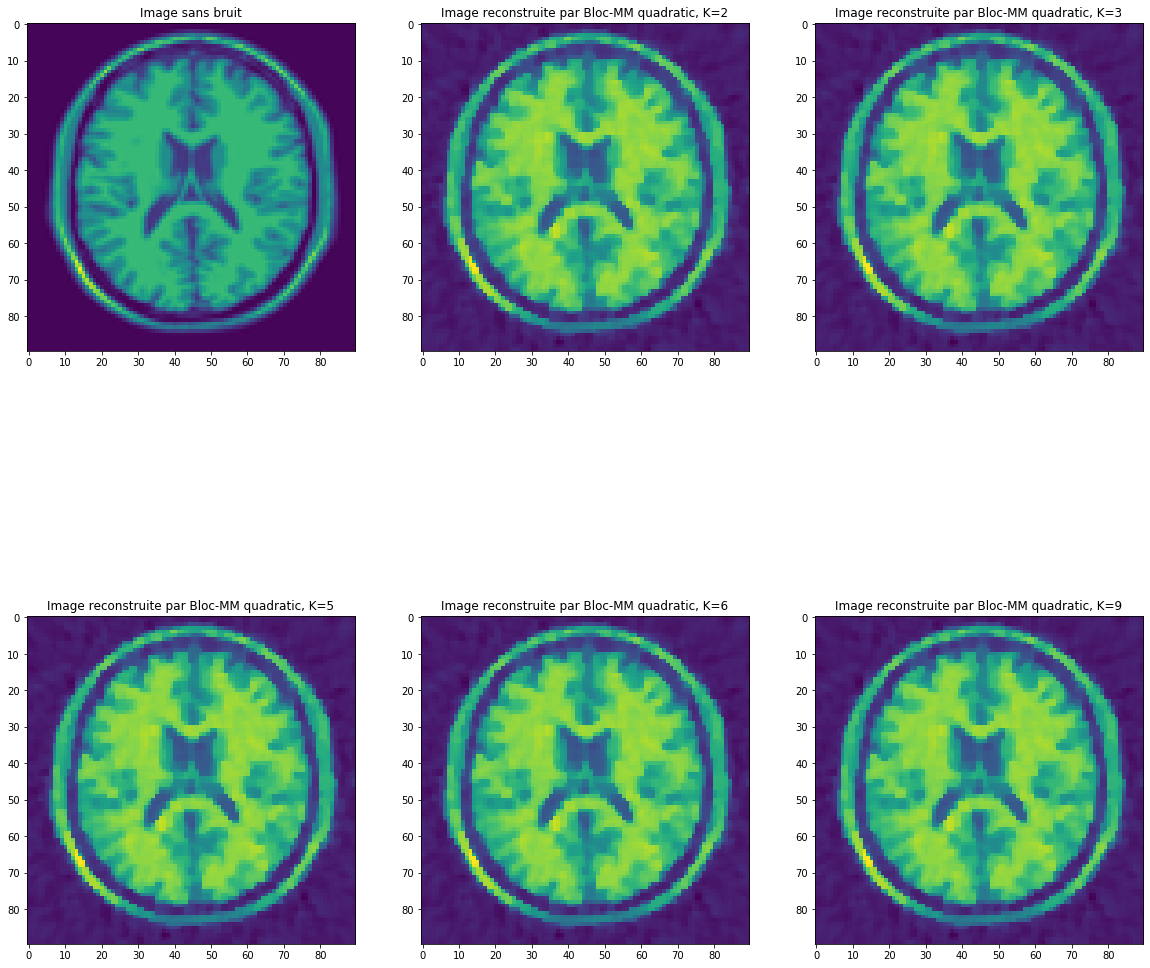

In [74]:
##On ne trace pas K=1 car il s'agit du cas classique MM-quadractic vu au début
fig, a = plt.subplots(2,3,figsize=(20,20))
a[0,0].set_title('Image sans bruit')
a[0,0].imshow(x.reshape(90,90,order='F'))
a[0,1].set_title('Image reconstruite par Bloc-MM quadratic, K=2')
a[0,1].imshow(x_bloc_quad.reshape(90,90,order='F'))
a[0,2].set_title('Image reconstruite par Bloc-MM quadratic, K=3')
a[0,2].imshow(x_bloc_quad_3.reshape(90,90,order='F'))
a[1,0].set_title('Image reconstruite par Bloc-MM quadratic, K=5')
a[1,0].imshow(x_bloc_quad_5.reshape(90,90,order='F'))
a[1,1].set_title('Image reconstruite par Bloc-MM quadratic, K=6')
a[1,1].imshow(x_bloc_quad_6.reshape(90,90,order='F'))
a[1,2].set_title('Image reconstruite par Bloc-MM quadratic, K=9')
a[1,2].imshow(x_bloc_quad_9.reshape(90,90,order='F'))


### Parallel MM quadratic algorithm

Calculons pour tout x,
$$x^{T}(B(x)-A(x))x$$

$x^{T}(B(x)-A(x))x = \sum_{i=1}^{N} b^{(i)}(x)x_{i}^{2} - x^{T}A(x)x$, avec $A(x) = H^{T}Hx + \lambda G^{T} \left(\frac{\phi^{.}(Gx)}{Gx}\right)$

Montrons d'abord que $\sum_{i=1}^{N} \mathcal{H}_{i}^{T} \mathbf{1} x_{i}^{2} - x^{T}H^{T}Hx \geq 0$

On a d'abord :
$x^{T}H^{T}Hx = \|Hx\|^{2} = \sum_{j=1}^{M} <H_{j},x>^{2} \ \leq \ \sum_{j=1}^{M} <abs(H_{j}),abs(x)>^{2}$

Avec $abs(.) = \|.\|_{1} $

Or,
$\sum_{j=1}^{M} <abs(H_{j}),abs(x)>^{2} \ = \ \sum_{j=1}^{M} <\frac{abs(H_{j})\sum_{i=1}^{N} abs(H_{i,j})}{\sum_{i=1}^{N} abs(H_{i,j})},abs(x) >^{2} \ = \
\sum_{j=1}^{M} \left(\sum_{i=1}^{N} abs(H_{i,j})\right)^{2} <\frac{abs(H_{j})}{\sum_{i=1}^{N} abs(H_{i,j})},abs(x)>^{2}$

Posons $\lambda_{i,j} = \frac{abs(H_{i,j})}{\sum_{k=1}^{N} abs(H_{k,j})}$

Pour tout $1 \leq j \leq M$,
$$\sum_{i=1}^{N} \lambda_{i,j} = 1$$

On applique alors l'inégalité de Jensen à la fonction $x \mapsto  x^{2}$

On a donc :
$$x^{T}H^{T}Hx \leq 
\sum_{j=1}^{M} \left(\sum_{i=1}^{N} abs(H_{i,j})\right)^{2} \sum_{k=1}^{N} \lambda_{k,j} x_{k}^{2} \ = \
\sum_{j=1}^{M} \left(\sum_{i=1}^{N} abs(H_{i,j})\right) \sum_{k=1}^{N} abs(H_{k,j}) x_{k}^{2} \ = \
\sum_{k=1}^{N} \mathcal{H}_{k}^{T} \mathbf{1} x_{k}^{2}$$

Un raisonnement analogue donne la même égalité pour le terme avec la matrice $G$.

On en déduit que pour tout x, $$ B(x) \succcurlyeq A(x)$$

Pour obtenir un algorithme Parallel MM Quadractic, il faut implémenter une fonction renvoyant $B(x)$ pour tout $x$. Ensuite, on applique séparement l'algorihme MM quadractic classique à chaque coordonée de $x$ car la matrice  $B(x)$ est diagonale. On trouve ainsi un minimiseur de $f$.

### Comparison of the methods

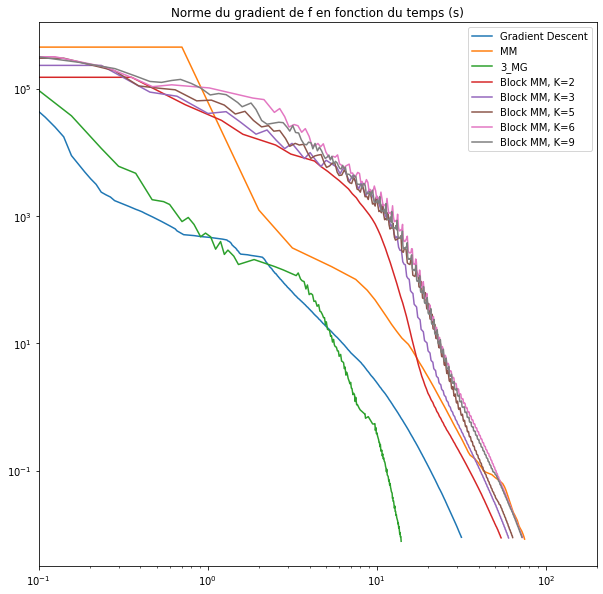

In [82]:
plt.figure(figsize=(10,10))
time_desc, err_desc  = zip(*sorted(times_desc.items()))
time_mm, err_mm  = zip(*sorted(times_mm.items()))
time_3mg, err_3mg  = zip(*sorted(times_3mg.items()))
time_b, err_b  = zip(*sorted(times_bloc.items()))
time_b3, err_b3  = zip(*sorted(times_bloc_3.items()))
time_b5, err_b5  = zip(*sorted(times_bloc_5.items()))
time_b6, err_b6  = zip(*sorted(times_bloc_6.items()))
time_b9, err_b9  = zip(*sorted(times_bloc_9.items()))

plt.loglog(time_desc, err_desc, label='Gradient Descent')
plt.loglog(time_mm, err_mm, label='MM')
plt.loglog(time_3mg, err_3mg, label='3_MG')
plt.loglog(time_b, err_b, label='Block MM, K=2')
plt.loglog(time_b3, err_b3, label='Block MM, K=3')
plt.loglog(time_b5, err_b5, label='Block MM, K=5')
plt.loglog(time_b6, err_b6, label='Block MM, K=6')
plt.loglog(time_b9, err_b9, label='Block MM, K=9')
plt.xlim([0.1,200])
plt.title('Norme du gradient de f en fonction du temps (s)')
plt.legend()
plt.show()